In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from datetime import datetime
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import gc
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout,ZeroPadding2D, Add, GlobalAveragePooling2D, DepthwiseConv2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D, AveragePooling2D, Flatten, Dense, Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import precision_recall_curve,  plot_precision_recall_curve,  classification_report,  confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from imutils import paths

In [ ]:
!unzip "/content/drive/MyDrive/PneumoniaCovidDetection/out.zip" -d "./"

Streaming output truncated to the last 5000 lines.
  inflating: ./out/val/covid/COVID-19 (37).jpg  
  inflating: ./out/val/covid/COVID-19 (84).jpg  
  inflating: ./out/val/covid/COVID-19 (238).jpg  
  inflating: ./out/val/covid/099.jpeg  
  inflating: ./out/val/covid/COVID-19 (227).jpg  
  inflating: ./out/val/covid/043.JPG  
  inflating: ./out/val/covid/479.jpg  
  inflating: ./out/val/covid/COVID-19 (642).jpg  
  inflating: ./out/val/covid/COVID-19 (12).jpg  
  inflating: ./out/val/covid/COVID-19 (645).jpg  
  inflating: ./out/val/covid/COVID19(452).jpg  
  inflating: ./out/val/covid/159.jpeg  
  inflating: ./out/val/covid/117.jpeg  
  inflating: ./out/val/covid/COVID-19 (606).jpg  
  inflating: ./out/val/covid/COVID-19 (39).jpg  
  inflating: ./out/val/covid/COVID-19 (16).jpeg  
  inflating: ./out/val/covid/383.PNG  
  inflating: ./out/val/covid/COVID-19 (757).jpg  
  inflating: ./out/val/covid/067.jpeg  
  inflating: ./out/val/covid/217.jpg  
  inflating: ./out/val/covid/COVID19(40

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=r"./out/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

train_generator = train_datagen.flow_from_directory(
        directory=r"./out/train/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )

valid_generator = val_datagen.flow_from_directory(
        directory=r"./out/val/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )

Found 1379 images belonging to 3 classes.
Found 4830 images belonging to 3 classes.
Found 693 images belonging to 3 classes.


In [ ]:
class_to_label_map = {'pneumonia' : 2, 'covid' : 1, 'normal' : 0}

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4096, 
                activation = 'relu'
                #kernel_regularizer= keras.regularizers.l2(l2=0.1)
                ))
model.add(BatchNormalization())
model.add(Dense(4096, 
                activation = 'relu'
                #kernel_regularizer= keras.regularizers.l2(l2=0.1)
                ))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              5246976   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Creating LR Scheduler
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=755,
    decay_rate=0.9,
    staircase=True)

METRICS = ['accuracy',
           tf.keras.metrics.AUC(name="AUC"),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
    ]


model.compile(optimizer= Adam(lr_schedule), loss='binary_crossentropy', metrics=METRICS)

#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    #class_weight=class_weight,
                   )

Epoch 1/15
301/301 [==============================] - 117s 381ms/step - loss: 0.5671 - accuracy: 0.8536 - AUC: 0.9323 - precision: 0.8574 - recall: 0.8509 - val_loss: 0.2965 - val_accuracy: 0.8823 - val_AUC: 0.9524 - val_precision: 0.8830 - val_recall: 0.8779
Epoch 2/15
301/301 [==============================] - 113s 377ms/step - loss: 0.1898 - accuracy: 0.9061 - AUC: 0.9710 - precision: 0.9111 - recall: 0.9026 - val_loss: 0.1591 - val_accuracy: 0.9186 - val_AUC: 0.9736 - val_precision: 0.9196 - val_recall: 0.9142
Epoch 3/15
301/301 [==============================] - 114s 380ms/step - loss: 0.1527 - accuracy: 0.9184 - AUC: 0.9782 - precision: 0.9228 - recall: 0.9132 - val_loss: 0.1484 - val_accuracy: 0.9244 - val_AUC: 0.9806 - val_precision: 0.9283 - val_recall: 0.9215
Epoch 4/15
301/301 [==============================] - 113s 375ms/step - loss: 0.1419 - accuracy: 0.9263 - AUC: 0.9802 - precision: 0.9289 - recall: 0.9227 - val_loss: 0.1872 - val_accuracy: 0.9055 - val_AUC: 0.9693 - val

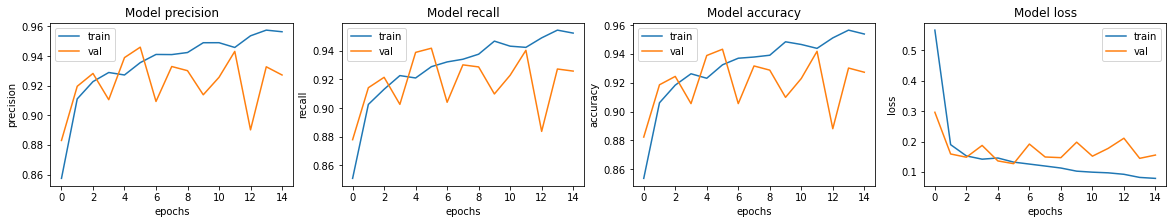

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.evaluate(valid_generator)

44/44 [==============================] - 9s 203ms/step - loss: 0.1544 - accuracy: 0.9278 - AUC: 0.9809 - precision: 0.9277 - recall: 0.9264


[0.15444234013557434,
 0.9278499484062195,
 0.9808890223503113,
 0.9277456402778625,
 0.9264069199562073]

In [ ]:
predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(len(test_generator)/1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
confusion_matrix(test_generator.labels, np.argmax(predict,axis=1))

array([[440,   5,   8],
       [ 22, 428,  13],
       [  5,  38, 420]])

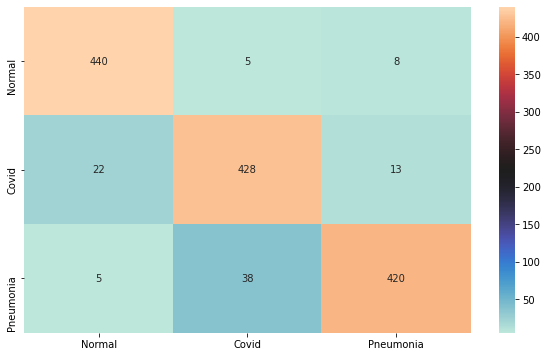

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(test_generator.labels, np.argmax(predict,axis=1)),annot=True,yticklabels=["Normal","Covid","Pneumonia"],xticklabels=["Normal","Covid","Pneumonia"],fmt="d",cmap = "icefire")

In [ ]:
print(classification_report(test_generator.labels, np.argmax(predict,axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       453
           1       0.91      0.92      0.92       463
           2       0.95      0.91      0.93       463

    accuracy                           0.93      1379
   macro avg       0.93      0.93      0.93      1379
weighted avg       0.93      0.93      0.93      1379



In [ ]:
for layer in base_model.layers[:165]:
    layer.trainable = False
for layer in base_model.layers[165:]:
    layer.trainable = True

In [ ]:
# Learning Rate
initial_learning_rate = 1e-5

# Learning Rate Scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=755,
    decay_rate=0.9,
    staircase=True)

# Creating Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max',patience=4,
                                                     restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),  # Very slow learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
from keras.callbacks import EarlyStopping

history_new = model.fit(train_generator,
                        epochs=20,
                        steps_per_epoch = 4834 // 32,
                        validation_data = valid_generator,
                        validation_steps = 624 // 32,
                        callbacks=[checkpoint_cb, early_stopping_cb],)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


151/151 [==============================] - 61s 383ms/step - loss: 0.0966 - accuracy: 0.9486 - AUC: 0.9874 - precision: 0.9451 - recall: 0.9421 - val_loss: 0.3182 - val_accuracy: 0.8717 - val_AUC: 0.9526 - val_precision: 0.8713 - val_recall: 0.8684


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
151/151 [==============================] - 57s 375ms/step - loss: 0.1012 - accuracy: 0.9528 - AUC: 0.9866 - precision: 0.9567 - recall: 0.9511 - val_loss: 0.2184 - val_accuracy: 0.9079 - val_AUC: 0.9628 - val_precision: 0.9109 - val_recall: 0.9079
Epoch 3/20
151/151 [==============================] - 57s 378ms/step - loss: 0.0984 - accuracy: 0.9474 - AUC: 0.9883 - precision: 0.9493 - recall: 0.9453 - val_loss: 0.1978 - val_accuracy: 0.9243 - val_AUC: 0.9726 - val_precision: 0.9269 - val_recall: 0.9178
Epoch 4/20
151/151 [==============================] - 55s 366ms/step - loss: 0.1090 - accuracy: 0.9412 - AUC: 0.9867 - precision: 0.9423 - recall: 0.9396 - val_loss: 0.3705 - val_accuracy: 0.8882 - val_AUC: 0.9437 - val_precision: 0.8882 - val_recall: 0.8882
Epoch 5/20
151/151 [==============================] - 58s 385ms/step - loss: 0.0999 - accuracy: 0.9474 - AUC: 0.9874 - precision: 0.9493 - recall: 0.9461 - val_loss: 0.1832 - val_accuracy: 0.9408 - val_AUC: 0.9799 - val_pre

In [ ]:
model.evaluate(valid_generator)

44/44 [==============================] - 9s 202ms/step - loss: 0.1616 - accuracy: 0.9394 - AUC: 0.9755 - precision: 0.9407 - recall: 0.9380


[0.1616249680519104,
 0.939393937587738,
 0.9755367040634155,
 0.9406657218933105,
 0.9379509091377258]

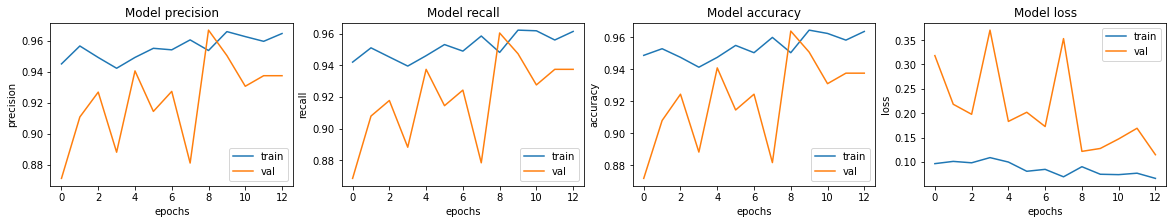

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_new.history[met])
    ax[i].plot(history_new.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
predict_new = model.predict_generator(test_generator,steps = 
                                   np.ceil(len(test_generator)/1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
confusion_matrix(test_generator.labels, np.argmax(predict_new,axis=1))

array([[439,  13,   1],
       [ 19, 429,  15],
       [  7,  33, 423]])

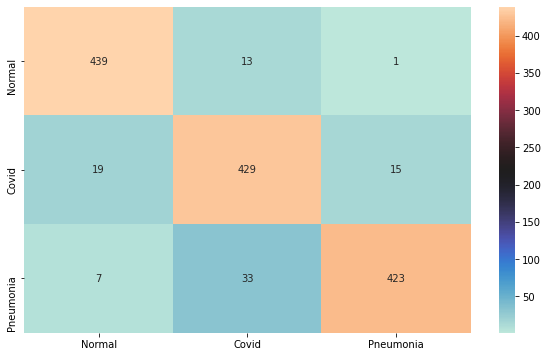

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(test_generator.labels, np.argmax(predict_new,axis=1)),annot=True,yticklabels=["Normal","Covid","Pneumonia"],xticklabels=["Normal","Covid","Pneumonia"],fmt="d",cmap = "icefire")

In [ ]:
print(classification_report(test_generator.labels, np.argmax(predict_new,axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       453
           1       0.90      0.93      0.91       463
           2       0.96      0.91      0.94       463

    accuracy                           0.94      1379
   macro avg       0.94      0.94      0.94      1379
weighted avg       0.94      0.94      0.94      1379



In [ ]:
y_true=test_generator.classes[test_generator.index_array] 

In [ ]:
y_pred = np.squeeze(model.predict_classes(test_generator))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       453
           1       0.90      0.93      0.91       463
           2       0.96      0.91      0.94       463

    accuracy                           0.94      1379
   macro avg       0.94      0.94      0.94      1379
weighted avg       0.94      0.94      0.94      1379



In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns


# sns.heatmap(confusion_matrix(y_true,y_pred),annot=True)

In [ ]:
# cm = confusion_matrix(y_true,y_pred)

# tn, fp, fn, tp = cm.ravel()

# precision = tp/(tp+fp)
# recall = tp/(tp+fn)

# print("Recall of the model is {:.2f}".format(recall))
# print("Precision of the model is {:.2f}".format(precision))